In [4]:
#Imports

#Basic Imports
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import zipfile

#Plotting
import seaborn as sns
%matplotlib inline
sns.set_style('white')

#Models
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm


#Data Infrastructure Pieces
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.model_selection import cross_val_score

In [5]:
zf = zipfile.ZipFile("student.zip")
df = pd.read_csv(zf.open('student-mat.csv'),sep = ";")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        395 non-null object
sex           395 non-null object
age           395 non-null int64
address       395 non-null object
famsize       395 non-null object
Pstatus       395 non-null object
Medu          395 non-null int64
Fedu          395 non-null int64
Mjob          395 non-null object
Fjob          395 non-null object
reason        395 non-null object
guardian      395 non-null object
traveltime    395 non-null int64
studytime     395 non-null int64
failures      395 non-null int64
schoolsup     395 non-null object
famsup        395 non-null object
paid          395 non-null object
activities    395 non-null object
nursery       395 non-null object
higher        395 non-null object
internet      395 non-null object
romantic      395 non-null object
famrel        395 non-null int64
freetime      395 non-null int64
goout         395 non-null int64
Dalc          395 no

In [6]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [9]:
df_dumb = pd.get_dummies(df[['sex', 'higher', 'famsup']],drop_first=True)
df_dumb.head()
df_newc = pd.concat([df_dumb,df[['age']]], axis=1)

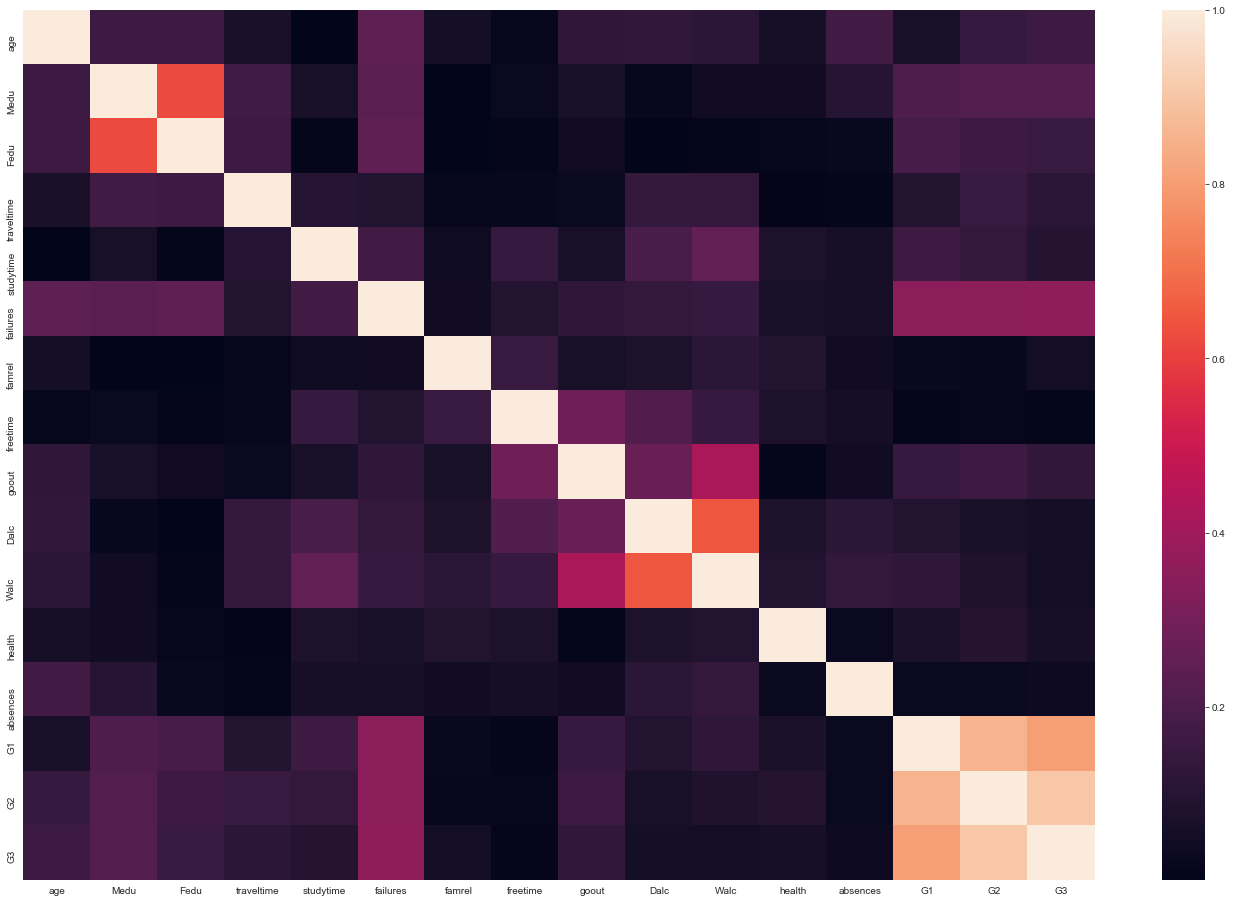

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(24, 16)
sns.heatmap(df.corr().abs())

## Models

### Test Train Split

In [15]:
X = df_newc[['sex_M', 'famsup_yes']]
Y = df_newc['higher_yes']

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.25)

### Vanilla Logistic Regression

In [16]:
# Declare predictors.
X_statsmod = X_train.copy()

# The Statsmodels formulation requires a column with constant value 1 that
# will act as the intercept.
#X_statsmod['intercept'] = 1 

# Declare and fit the model.
logit = sm.Logit(Y_train, X_statsmod)
result = logit.fit(maxiter=1000)

# Lots of information about the model and its coefficients, but the
# accuracy rate for predictions is missing.
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.161787
         Iterations 8
                        Results: Logit
Model:              Logit            Pseudo R-squared: inf     
Dependent Variable: higher_yes       AIC:              99.7777 
Date:               2019-04-21 15:04 BIC:              107.1584
No. Observations:   296              Log-Likelihood:   -47.889 
Df Model:           1                LL-Null:          0.0000  
Df Residuals:       294              LLR p-value:      1.0000  
Converged:          1.0000           Scale:            1.0000  
No. Iterations:     8.0000                                     
----------------------------------------------------------------
                Coef.   Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------
sex_M           1.6766    0.3282  5.1087  0.0000  1.0334  2.3199
famsup_yes      3.3898    0.5090  6.6602  0.0000  2.3922  4.3873



C:\Users\postgres\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\postgres\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\postgres\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:3313: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


In [17]:
df_newc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 4 columns):
sex_M         395 non-null uint8
higher_yes    395 non-null uint8
famsup_yes    395 non-null uint8
age           395 non-null int64
dtypes: int64(1), uint8(3)
memory usage: 4.3 KB


In [18]:
# Calculate accuracy. First, get probability that each row will be admitted.
pred_statsmod = result.predict(X_statsmod)

# Code admission as 1 if probability is greater than .5.
pred_Y_statsmod = np.where(pred_statsmod < .5, 0, 1)

# Accuracy table.
table = pd.crosstab( pred_Y_statsmod,Y_train)

print('\n Accuracy by admission status')
print(table)
print('\n Percentage accuracy')
print((table.iloc[0,0] + table.iloc[1,1]) / (table.sum().sum()))


 Accuracy by admission status
higher_yes   0    1
row_0              
1           14  282

 Percentage accuracy


IndexError: single positional indexer is out-of-bounds

### Ridge Logistic Regression

In [19]:
ridgemodel = LogisticRegression(C=10, penalty='l2',solver = 'liblinear')
ridgemodel.fit(X_train, Y_train)
y_pred=ridgemodel.predict(X_test)
ridgemodel.score(X_test, Y_test)

0.9393939393939394

In [20]:
confusion_matrix(y_pred, Y_test)

array([[ 0,  0],
       [ 6, 93]], dtype=int64)

### Cross Validation Score

In [21]:
print(cross_val_score(ridgemodel, X_test, Y_test, cv=5))

[0.9047619  0.95       0.95       0.94736842 0.94736842]


## Lasso Regression

In [22]:
lassoR = LogisticRegression(C=.8, penalty='l1',solver = 'liblinear')
lassoR.fit(X_train, Y_train)
y_pred=lassoR.predict(X_test)
lassoR.score(X_test, Y_test)

0.9393939393939394

In [23]:
confusion_matrix(y_pred, Y_test)

array([[ 0,  0],
       [ 6, 93]], dtype=int64)

### Cross Validation

In [24]:
print(cross_val_score(lassoR, X_test, Y_test, cv=5))

[0.9047619  0.95       0.95       0.94736842 0.94736842]
